In [ ]:
!gdown 1-Fz1Bo_oBpzsop8buB7NbDhCqqIpixEl

Downloading...
From: https://drive.google.com/uc?id=1-Fz1Bo_oBpzsop8buB7NbDhCqqIpixEl
To: /content/kidStn512_aux.rar
100% 223M/223M [00:06<00:00, 34.0MB/s]


In [ ]:
!unrar x "/content/kidStn512_aux.rar"

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  kidStn512_aux/images/ct246_image84.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image85.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image86.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image87.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image88.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image92.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct246_image96.jpg                        95%  OK 
Extracting  kidStn512_aux/images/ct247_image100.jpg                       95%  OK 
Extracting  kidStn512_aux/images/ct247_image101.jpg                       95%  OK 
Extracting  kidStn512_aux/images/ct247_image107.jpg                       95%  OK 
Extracting  kidStn5

In [ ]:
import numpy as np
import nibabel as nib
import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tifffile import imsave
from PIL import Image
import cv2
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
import datetime, os

In [ ]:
#imagesList = os.listdir("/content/kidStn512_aux/images")
#num_images = len(imagesList)
num_images = 4000
n_classes = 3
print(num_images)

4000


In [ ]:
image_names = glob.glob("/content/kidStn512_aux/images/*.jpg")
image_names.sort()
image_names_subset = image_names[0:num_images]
images=[]
for image in image_names_subset:
  img = cv2.imread(image, 0)
  redim1 = cv2.resize(img, (256,256))
  images.append(redim1)
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset = image_dataset /255.

In [ ]:
mask_names = glob.glob("/content/kidStn512_aux/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks=[]
for mask in mask_names_subset:
  msk = cv2.imread(mask, 0)
  redim2 = cv2.resize(msk, (256,256))
  masks.append(redim2)
mask_dataset = np.array(masks)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (4000, 256, 256, 1)
Mask data shape is:  (4000, 256, 256)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2]


In [ ]:
'''
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)
'''

'\nfrom sklearn.preprocessing import LabelEncoder\nlabelencoder = LabelEncoder()\nn, h, w = mask_dataset.shape\nmask_dataset_reshaped = mask_dataset.reshape(-1,1)\nmask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)\nmask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)\n\nnp.unique(mask_dataset_encoded)\n'

In [ ]:
#mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)
print(mask_dataset_encoded.shape)

(4000, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
### Modelo ResUNet++

import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='softmax', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x


    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attention_block(g, x):

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 1))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attention_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attention_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attention_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## Output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(3, (1, 1), padding="same")(outputs)
        outputs = Activation("softmax")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
## ResUnet++
arch = ResUnetPlusPlus(input_size=256)
model = arch.build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = TensorBoard(logdir, histogram_freq=1)
#tensorboard = TensorBoard(log_dir="logs1/{}".format(time()))
csv_logger = CSVLogger('resultsResUnetPlus.log', separator=",", append=False)
log = model.fit(X_train, y_train_cat, batch_size=16, epochs=30, validation_data=(X_test, y_test_cat), shuffle=False, callbacks=[csv_logger])

Epoch 1/30
200/200 [==============================] - 78s 174ms/step - loss: 0.2525 - accuracy: 0.9462 - val_loss: 0.1581 - val_accuracy: 0.9698
Epoch 2/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.1503 - val_accuracy: 0.9698
Epoch 3/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.0797 - val_accuracy: 0.9726
Epoch 4/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.0275 - val_accuracy: 0.9911
Epoch 5/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0259 - val_accuracy: 0.9918
Epoch 6/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0152 - val_accuracy: 0.9950
Epoch 7/30
200/200 [==============================] - 31s 153ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0156 - val_ac

In [ ]:
#Guardar modelo
model.save('ResUnetPlus.hdf5')

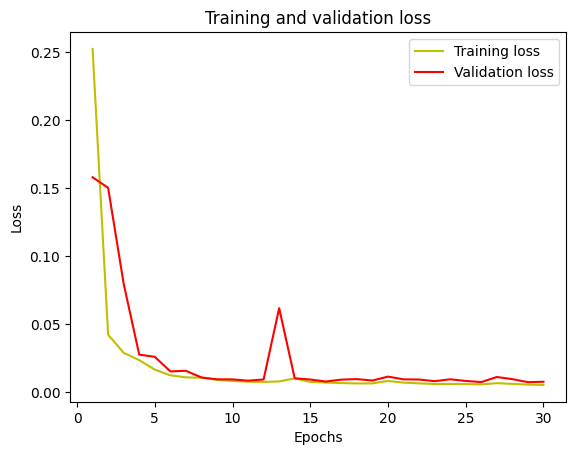

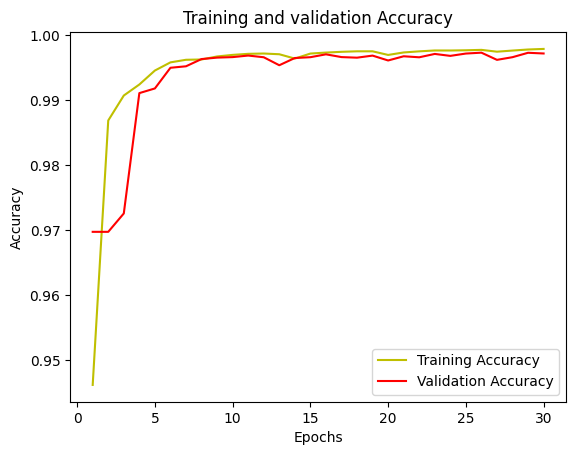

In [ ]:
loss = log.history['loss']
val_loss = log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model("ResUnetPlus.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_test)

25/25 [==============================] - 6s 60ms/step


In [ ]:
y_pred.shape

(800, 256, 256, 3)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(800, 256, 256)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.78972024


In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

[[1.6777216e+07 2.2489000e+04 2.5547000e+04]
 [2.6230000e+04 8.3081000e+04 4.9068000e+04]
 [1.7838000e+04 7.4650000e+03 1.4021930e+06]]
IoU for class1 is:  0.99454015
IoU for class2 is:  0.44113883
IoU for class3 is:  0.93348163


1/1 [==============================] - 2s 2s/step


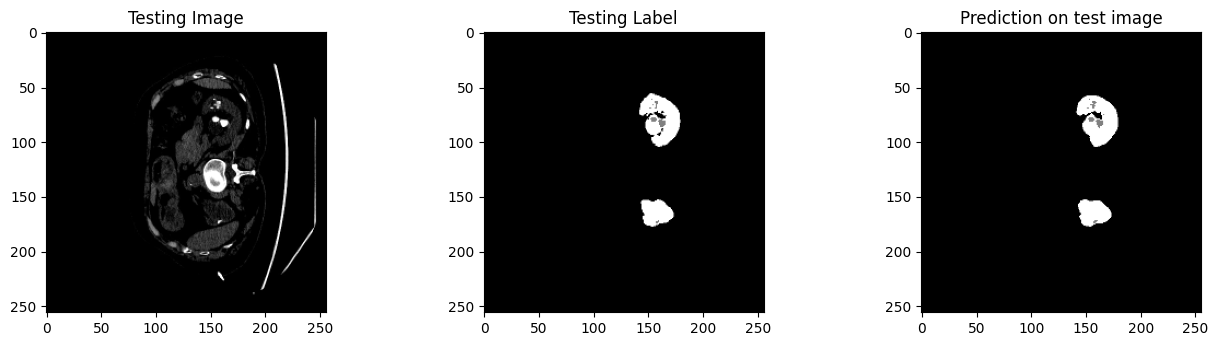

In [ ]:
#Predicciones
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

1/1 [==============================] - 0s 30ms/step


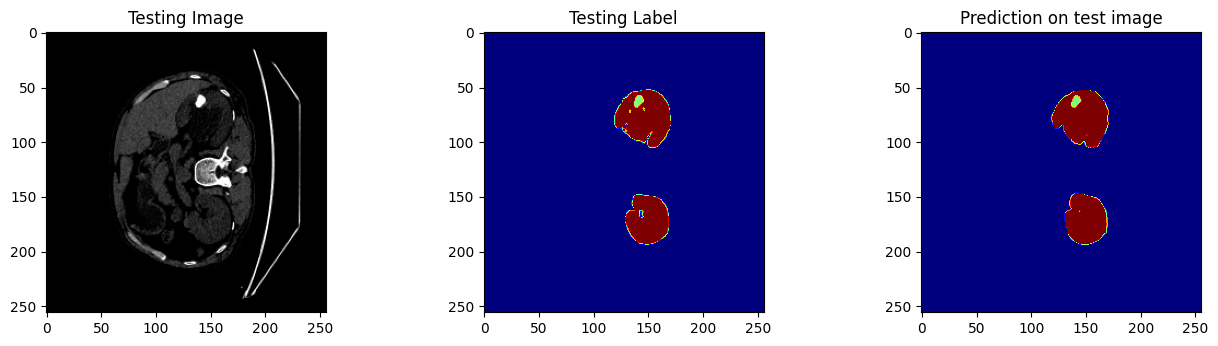

In [ ]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()